In [1]:
import sys
sys.path.append('..')

import warnings
warnings.filterwarnings("ignore")

import os
import torch
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import KFold

from uncertain.utils.data import Data
from uncertain.utils.training import train
from uncertain.utils.evaluation import test

from uncertain.explicit import Bias, MF, CPMF, OrdRec, BeMF
from uncertain.extras import Ensemble, Resample, UncertainWrapper, UserHeuristic, ItemHeuristic

from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS
import seaborn as sns

os.chdir('Movielens')

if os.path.isfile('data.pkl'):
    with open('data.pkl', 'rb') as f:
        data = pickle.load(f)
    print(f'MovieLens data prepared: {data.n_user} users, {data.n_item} items.')
    print(f'{len(data.train)} train, {len(data.val)} validation and {len(data.test)} test interactions.')
else:
    data = pd.read_csv('data.csv')
    data.columns = ['user', 'item', 'score', 'timestamps']
    data = Data(data, implicit=False, users_on_test=1000)
    with open('data.pkl', 'wb') as f:
        pickle.dump(data, f, protocol=4)

MovieLens data prepared: 6040 users, 3416 items.
871984 train, 93970 validation and 33657 test interactions.


In [2]:
data.user

,support,variance,diversity
user,,,
0,341,1.391737,0.777067
1,99,0.541950,0.749573
2,20,1.221053,0.741677
3,202,0.770726,0.743612
4,888,1.047928,0.837847
...,...,...,...
6035,29,0.662562,0.700928
6036,343,1.624060,0.811571
6037,268,1.079588,0.731402


# ExplicitMF (FunkSVD)

In [ ]:
for dim in [50, 100, 200]:
    for wd in [0.1, 0.01, 0.001]:
        model = MF(data.n_user, data.n_item, embedding_dim=dim, lr=0.00001, weight_decay=wd)
        train(model, data, path='checkpoints/baseline', name=f'dim={dim}-wd={wd}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test(model, data, name='Baseline', max_k=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 302 K 
1 | item_embeddings | Embedding | 170 K 
----------------------------------------------
472 K     Trainable params
0         Non-trainable params
472 K     Total params
1.891     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...
Trainer was signaled to stop but required minimum epochs (20) or minimum steps (None) has not been met. Training will continue...


In [12]:
# Load baseline
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
baseline = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
baseline = baseline.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))

# Ensemble

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/vcoscrato/.local/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

'Success!'

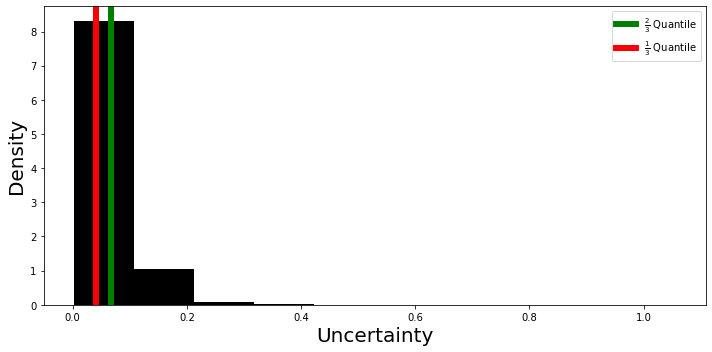

In [17]:
for i in range(4):
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=baseline.lr, weight_decay=baseline.weight_decay)
    train(model, data, path='checkpoints/ensemble', name=f'{i}')

models = [baseline]
for file in os.listdir('checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
test(ensemble, data, name='Ensemble', max_k=10)

# Resample

In [5]:
og = deepcopy(data.train)
for i in range(5):
    data.train = og[np.random.choice(len(og), int(0.8*len(og)), replace=False), :]
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=baseline.lr, weight_decay=baseline.weight_decay)
    train(model, data, path='checkpoints/resample', name=f'{i}')
data.train = og

# Resample
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(baseline, models)
test(resample, data, name='Resample', max_k=10, use_baseline=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

  0%|          | 0/6040 [00:00<?, ?it/s]

'Success!'

# Zhu et. al

In [6]:
errors = np.empty(len(data.train))
og = deepcopy(data.train)
og_val = deepcopy(data.val)
for i, (train_idx, test_idx) in enumerate(KFold(n_splits=2, shuffle=True).split(data.train)):
    test_rat = og[test_idx]
    data.train = og[train_idx]
    model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=baseline.weight_decay)
    train(model, data, path='checkpoints/cv', name=f'cv{i}')
    errors[test_idx] = np.abs(model.predict(torch.tensor(test_rat[:, 0]).long(), torch.tensor(test_rat[:, 1]).long()) - test_rat[:, 2])
data.train = deepcopy(og)
data.train[:, 2] = errors
data.val[:, 2] = np.abs(model.predict(torch.tensor(data.val[:, 0]).long(), torch.tensor(data.val[:, 1]).long()) - data.val[:, 2])

# DoubleMF
model = MF(data.n_user, data.n_item, embedding_dim=10, lr=0.0002, weight_decay=baseline.weight_decay)
train(model, data, path='checkpoints/cv', name=f'MF')

# Bias
model = Bias(data.n_user, data.n_item, lr=0.0002)
train(model, data, path='checkpoints/cv', name=f'Bias')

#Fix
data.train = og
data.val = og_val

# Zhu
for file in os.listdir('checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=10, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('checkpoints/cv', file))
bias_cv = UncertainWrapper(baseline, bias)
test(bias_cv, data, name='CV-Bias', max_k=10, use_baseline=True)
mf_cv = UncertainWrapper(baseline, mf)
test(mf_cv, data, name='CV-PMF', max_k=10, use_baseline=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type      | Params
----------------------------------------------
0 | user_embeddings | Embedding | 60.4 K
1 | item_embeddings | Embedding | 34.2 K
----------------------------------------------
94.6 K    Trainable params
0         Non-trainable params
94.6 K    Total params
0.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | user_bias | Embedding | 6.0 K 
1 | item_bias | Embedding | 3.4 K 
----------------------------------------
9.5 K     Trainable params
0         Non-trainable params
9.5 K     Total params
0.038     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

<IPython.core.display.Javascript object>

  0%|          | 0/6040 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

  0%|          | 0/6040 [00:00<?, ?it/s]

'Success!'

# CPMF

  0%|          | 0/1000 [00:00<?, ?it/s]

'Success!'

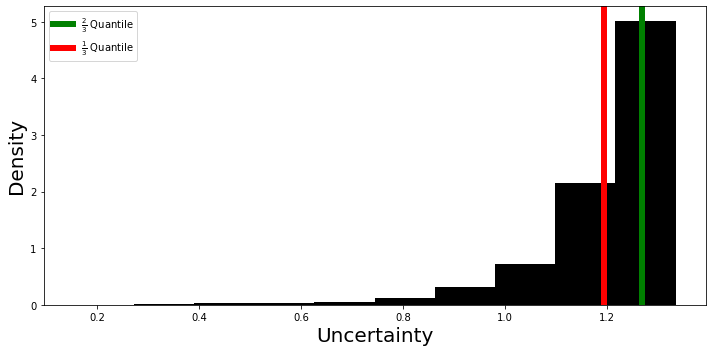

In [26]:
for lr in [0.00001, 0.000005, 0.000001]:
    model = CPMF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=lr, weight_decay=baseline.weight_decay, lr_var=lr)
    with torch.no_grad():
        model.user_embeddings.weight.copy_(baseline.user_embeddings.weight)
        model.item_embeddings.weight.copy_(baseline.item_embeddings.weight)
    train(model, data, path='checkpoints/cpmf', name=f'lr={lr}')

files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test(model, data, name='CPMF', max_k=10)

In [20]:
for lr in [0.00001, 0.000005]:
    model = CPMF(data.n_user, data.n_item, embedding_dim=baseline.embedding_dim, lr=lr, weight_decay=0, lr_var=lr)
    with torch.no_grad():
        model.user_embeddings.weight.copy_(baseline.user_embeddings.weight)
        model.item_embeddings.weight.copy_(baseline.item_embeddings.weight)

Parameter containing:
tensor([[ 0.0032, -0.0973,  0.2693,  ..., -0.1508, -0.0220, -0.1800],
        [ 0.0664, -0.0478,  0.1196,  ...,  0.0106,  0.0089, -0.1860],
        [ 0.1025,  0.0198,  0.1014,  ...,  0.0083,  0.0638, -0.1742],
        ...,
        [-0.1300,  0.0117,  0.1163,  ...,  0.1612,  0.0997, -0.1954],
        [ 0.2412,  0.0065,  0.0161,  ..., -0.0472, -0.0785, -0.2193],
        [ 0.1152, -0.0540,  0.1506,  ...,  0.0051, -0.0886, -0.1877]],
       requires_grad=True)

# OrdRec

  0%|          | 0/1000 [00:00<?, ?it/s]

'Success!'

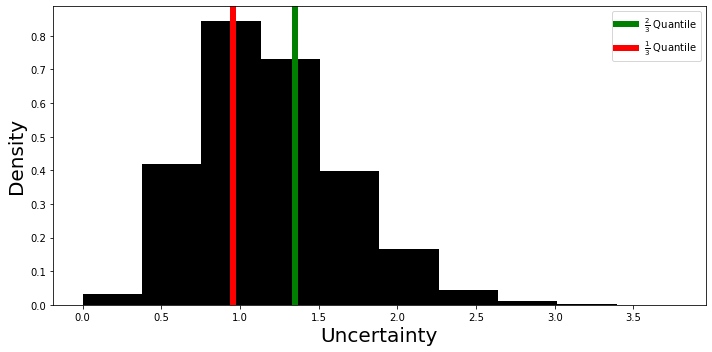

In [5]:
'''
data.to_ordinal()
for lr in [0.005, 0.001, 0.0005, 0.0001]:
    model = OrdRec(data.n_user, data.n_item, data.score_labels, embedding_dim=10, lr=0.0002, weight_decay=baseline.weight_decay, lr_step=lr)
    train(model, data, path='checkpoints/ordrec', name=f'lr={lr}')
'''
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/ordrec', min(files, key=files.get)))
test(model, data, name='OrdRec', max_k=10)

# BeMF

In [2]:
'''
data.to_ordinal()
for wd in [0.1, 0.01]:
    for lr in [0.01, 0.05]:
        model = BeMF(data.n_user, data.n_item, data.score_labels, embedding_dim=10, lr=lr, weight_decay=wd)
        train(model, data, path='checkpoints/bemf', name=f'wd={wd}-lr={lr}')
'''
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=10)
model = model.load_from_checkpoint(os.path.join('checkpoints/bemf', min(files, key=files.get)))
test(model, data, name='BeMF', max_k=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

'Success!'

1/data.user.support# Results

In [2]:
# Baseline
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/baseline')}
baseline = MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
baseline = baseline.load_from_checkpoint(os.path.join('checkpoints/baseline', min(files, key=files.get)))
test(baseline, data, name='Baseline', max_k=10)

# Heuristics
test(ItemHeuristic(base_MF=baseline, uncertainty=1/data.item.support.to_numpy()), data, name='Item_support', max_k=10, use_baseline=True)
test(ItemHeuristic(base_MF=baseline, uncertainty=data.item.variance.to_numpy()), data, name='Item_variance', max_k=10, use_baseline=True)

# Ensemble
models = [baseline]
for file in os.listdir('checkpoints/ensemble'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/ensemble', file))
ensemble = Ensemble(models)
test(ensemble, data, name='Ensemble', max_k=10)

# Resample
models = []
for file in os.listdir('checkpoints/resample'):
    models.append(MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0))
    models[-1] = models[-1].load_from_checkpoint(os.path.join('checkpoints/resample', file))
resample = Resample(baseline, models)
test(resample, data, name='Resample', max_k=10)

# Zhu
for file in os.listdir('checkpoints/cv'):
    if 'Bias' in file:
        bias = Bias(data.n_user, data.n_item, lr=0)
        bias = bias.load_from_checkpoint(os.path.join('checkpoints/cv', file))
    elif 'MF' in file:
        mf = MF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
        mf = mf.load_from_checkpoint(os.path.join('checkpoints/cv', file))
bias_cv = UncertainWrapper(baseline, bias)
test(bias_cv, data, name='CV-Bias', max_k=10)
mf_cv = UncertainWrapper(baseline, mf)
test(mf_cv, data, name='CV-PMF', max_k=10)

# CPMF
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/cpmf')}
model = CPMF(data.n_user, data.n_item, embedding_dim=0, lr=0, weight_decay=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/cpmf', min(files, key=files.get)))
test(model, data, name='CPMF', max_k=10)

# OrdRec
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/ordrec')}
model = OrdRec(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/ordrec', min(files, key=files.get)))
test(model, data, name='OrdRec', max_k=10)

# BeMF
score_labels = pd.factorize(data.train[:, 2], sort=True)[1]
files = {file: float(file.split('loss=')[1][:-5]) for file in os.listdir('checkpoints/bemf')}
model = BeMF(data.n_user, data.n_item, score_labels=score_labels, embedding_dim=0)
model = model.load_from_checkpoint(os.path.join('checkpoints/bemf', min(files, key=files.get)))
test(model, data, name='BeMF', max_k=10)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

'Success!'

In [3]:
# Load
results = {}
for key in os.listdir('results'):
    results[key.replace('.pkl', '').replace('_', ' ')] = pickle.load(open(os.path.join('results', key), 'rb'))
results = dict(sorted(results.items()))
colors = [c for c in list(TABLEAU_COLORS)] + ['k']
colors = {k:c for k, c in zip(results, colors)}

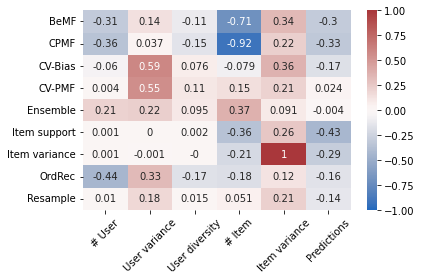

In [4]:
keys = [key for key in results if key != 'Baseline']
preds = pd.DataFrame(np.vstack([results[key]['uncertainty']['preds'][0] for key in keys]), index=keys)
unc = pd.DataFrame(np.vstack([results[key]['uncertainty']['preds'][1] for key in keys]), index=keys)
compare_user = data.user.loc[data.rand['users']].to_numpy()
compare_item = data.item.loc[data.rand['items']].to_numpy()
compare = pd.DataFrame(np.hstack((compare_user, compare_item)), columns = ['# User', 'User variance', 'User diversity', '# Item', 'Item variance'])
corr = pd.DataFrame([unc.corrwith(compare[key], axis=1) for key in compare.columns], index=compare.columns).T
corr['Predictions'] = preds.corrwith(unc, axis=1)
sns.heatmap(corr.round(3), annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/corr.pdf')

                   RMSE       RPI  Classification
Baseline       0.871449       NaN             NaN
BeMF           1.117433  0.586276        0.630029
CPMF           0.871358  0.087302        0.538532
CV-Bias        0.871449  0.728101        0.632386
CV-PMF         0.871449  0.689633        0.627789
Ensemble       0.871195  0.288006        0.538645
Item support        NaN  0.700621        0.522091
Item variance       NaN  0.399583        0.564779
OrdRec         0.885012  0.656954        0.643143
Resample       0.871449  0.436115        0.561125


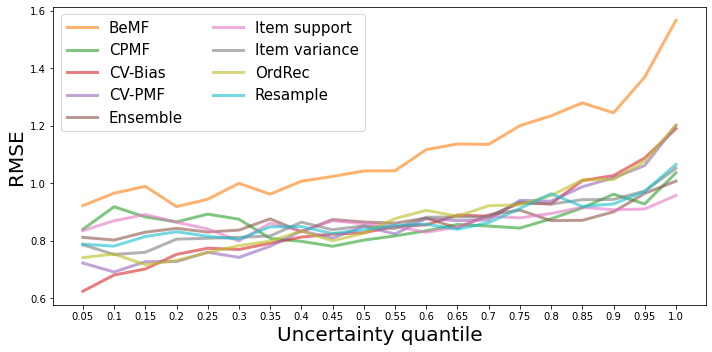

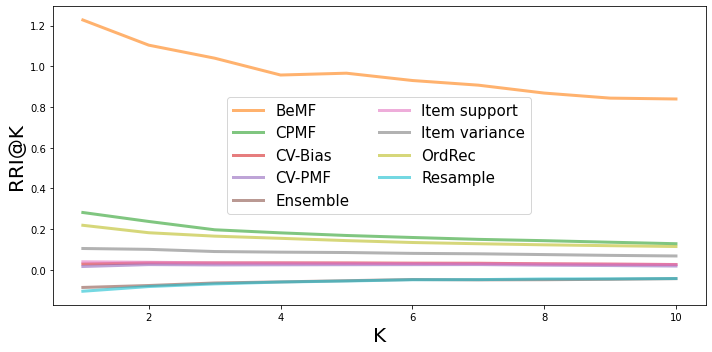

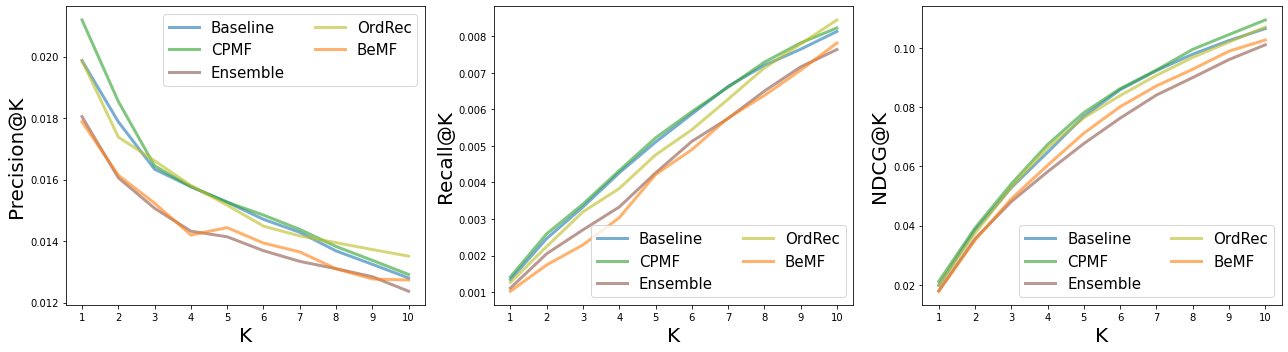

In [5]:
from matplotlib import pyplot as plt
from matplotlib.colors import TABLEAU_COLORS

# Rating prediction evaluation
ratings = pd.DataFrame([results[key]['ratings'] for key in results], index=results.keys())[['RMSE', 'RPI', 'Classification']]
print(ratings)

# Uncertainty-RMSE curve
keys = [key for key in results if key != 'Baseline']
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(np.arange(1, 21), results[key]['ratings']['Quantile RMSE'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xticks(np.arange(1, 21))
ax.set_xticklabels([round(elem, 2) for elem in np.linspace(start=0.05, stop=1, num=20).tolist()])
ax.set_xlabel('Uncertainty quantile', fontsize=20)
ax.set_ylabel('RMSE', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RMSE-uncertainty.pdf')

# RRI
f, ax = plt.subplots(figsize=(10, 5))
for key in keys:
    ax.plot(np.arange(1, 11), results[key]['uncertainty']['RRI'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax.set_xlabel('K', fontsize=20)
ax.set_ylabel('RRI@K', fontsize=20)
ax.legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/RRI.pdf')

# Top-K accuracy metrics
keys = ['Baseline', 'CPMF', 'Ensemble', 'OrdRec', 'BeMF']
f, ax = plt.subplots(ncols=3, figsize=(18, 5), sharex=True)
for key in keys:
    ax[0].plot(np.arange(1, 11), results[key]['accuracy']['Precision'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[1].plot(np.arange(1, 11), results[key]['accuracy']['Recall'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
    ax[2].plot(np.arange(1, 11), results[key]['accuracy']['NDCG'],
               '-', color=colors[key], label=key, linewidth=3, alpha=0.6)
ax[0].set_xticks(np.arange(1, 11))
ax[0].set_xlabel('K', fontsize=20)
ax[0].set_ylabel('Precision@K', fontsize=20)
ax[0].legend(ncol=2, fontsize=15)
ax[1].set_xlabel('K', fontsize=20)
ax[1].set_ylabel('Recall@K', fontsize=20)
ax[1].legend(ncol=2, fontsize=15)
ax[2].set_xlabel('K', fontsize=20)
ax[2].set_ylabel('NDCG@K', fontsize=20)
ax[2].legend(ncol=2, fontsize=15)
f.tight_layout()
f.savefig('plots/accuracy.pdf')

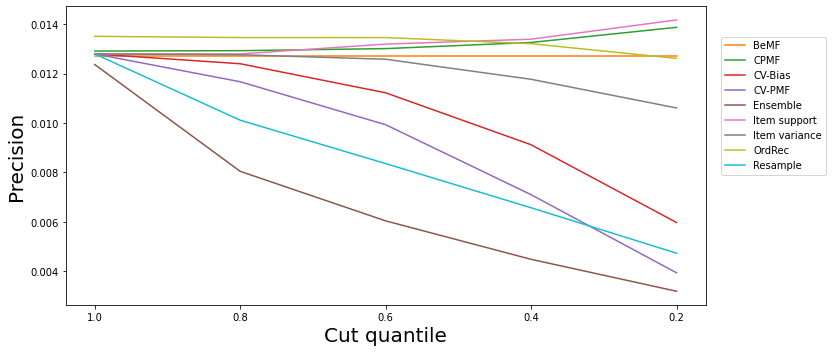

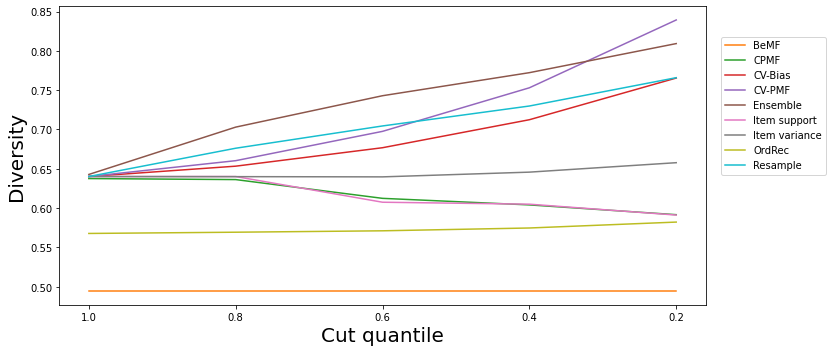

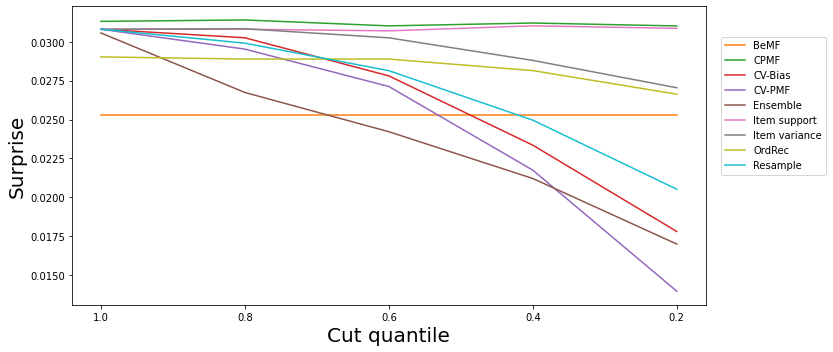

In [6]:
def retrieve_metric(metric, key):
    try:
        out = results[key]['accuracy'][metric][-1]
    except:
        out = results['Baseline']['accuracy'][metric][-1]
    return [out] + [results[key]['cuts'][cut][metric][-1] for cut in range(4)]

# Rating prediction evaluation
cuts_results = {metric: {key: retrieve_metric(metric, key) for key in results if key not in ['Baseline', 'User support']} for metric in ['Precision', 'Diversity', 'Surprise']}
for metric, value in cuts_results.items():
    f, ax = plt.subplots(figsize=(10, 5))
    for model, results_model in value.items():
        ax.plot(range(5), results_model, color=colors[model], label=model)
    ax.set_ylabel(metric, fontsize=20)
    ax.set_xticks(range(5))
    ax.set_xticklabels(np.linspace(1, 0.2, 5).round(2))
    ax.set_xlabel('Cut quantile', fontsize=20)
    f.legend(bbox_to_anchor=(1,0.9), loc="upper left")
    f.tight_layout()

In [7]:
# Rating prediction evaluation
a = {metric: {key: [results[key]['accuracy'][metric][-1]] + [results[key]['uncertain_accuracy'][metric][-1]] 
              for key in ['Ensemble', 'CV-Bias', 'CV-PMF', 'CPMF', 'OrdRec']} for metric in ['Precision', 'Diversity', 'Surprise']}
for key in a:
    print(f'\n {key}:')
    print(pd.DataFrame(a[key], index=['Standard', 'Uncertain']).T)


 Precision:
          Standard  Uncertain
Ensemble  0.012368   0.007086
CV-Bias   0.012798   0.011755
CV-PMF    0.012798   0.011921
CPMF      0.012914   0.015927
OrdRec    0.013510   0.013510

 Diversity:
          Standard  Uncertain
Ensemble  0.642811   0.742418
CV-Bias   0.640180   0.665920
CV-PMF    0.640180   0.672915
CPMF      0.637586   0.546852
OrdRec    0.567792   0.567792

 Surprise:
          Standard  Uncertain
Ensemble  0.030568   0.023500
CV-Bias   0.030806   0.028868
CV-PMF    0.030806   0.029820
CPMF      0.031312   0.031524
OrdRec    0.029028   0.029028
